In [1]:
import os
import wandb
import argparse

import torch
import numpy as np
import torch.nn as nn
import albumentations as A

from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [2]:
import sys
sys.path.append("../")
from src.pascal_voc import PascalVOCDataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare the dataset
---

In [4]:
# get dataset
PASCAL_VOC_MEAN, PASCAL_VOC_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

train_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=PASCAL_VOC_MEAN, std=PASCAL_VOC_STD),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=PASCAL_VOC_MEAN, std=PASCAL_VOC_STD),
    ToTensorV2()
])

In [19]:
train_dataset = PascalVOCDataset(root='/trinity/home/d.kuznedelev/Datasets', year='2012', image_set='train', transform=train_transforms)
test_dataset = PascalVOCDataset(root='/trinity/home/d.kuznedelev/Datasets', year='2012', image_set='val', transform=test_transforms)
# get train and test loader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Load model
---

In [5]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# number of classes in Pascal VOC
num_classes = 21

In [8]:
model = deeplabv3_mobilenet_v3_large(
    pretrained=False, 
    pretrained_backbone=True,
    num_classes=num_classes
)

model = model.to(device)

In [40]:
checkpoint_path = 'checkpoints/PascalVOC/from_scratch/DeepLabV3MobileNetV3_large/best.pt'
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
# put to evaluation mode
model.eval();

### Visualize predictions
---

In [28]:
def get_random_colors(n_colors):
    return np.random.randint(low=0, high=256, size=(n_colors, 3))

def tensor_to_image(x, mean=PASCAL_VOC_MEAN, std=PASCAL_VOC_STD):
    x = x.permute(1, 2, 0).cpu().numpy()
    x = x * np.array(std).reshape(1, 1, 3) + np.array(mean).reshape(1, 1, 3)
    x = np.clip(x, 0, 1)
    return x

def tensor_to_numpy(x):
    return x.cpu().numpy()

In [17]:
# create random colors
colors = get_random_colors(num_classes)

In [20]:
images, masks = next(iter(train_loader))

In [25]:
# put images to device
predicted_masks = model(images.to(device))['out']
# take the argmax of logits
predicted_masks = predicted_masks.argmax(dim=1)

In [31]:
# cast to numpy
gt_masks, pr_masks = tensor_to_numpy(masks), tensor_to_numpy(predicted_masks)
# colorize
gt_masks, pr_masks = colors[gt_masks], colors[pr_masks]

First row is the original image.

Second row is the ground truth mask.

Third row is predicted mask.

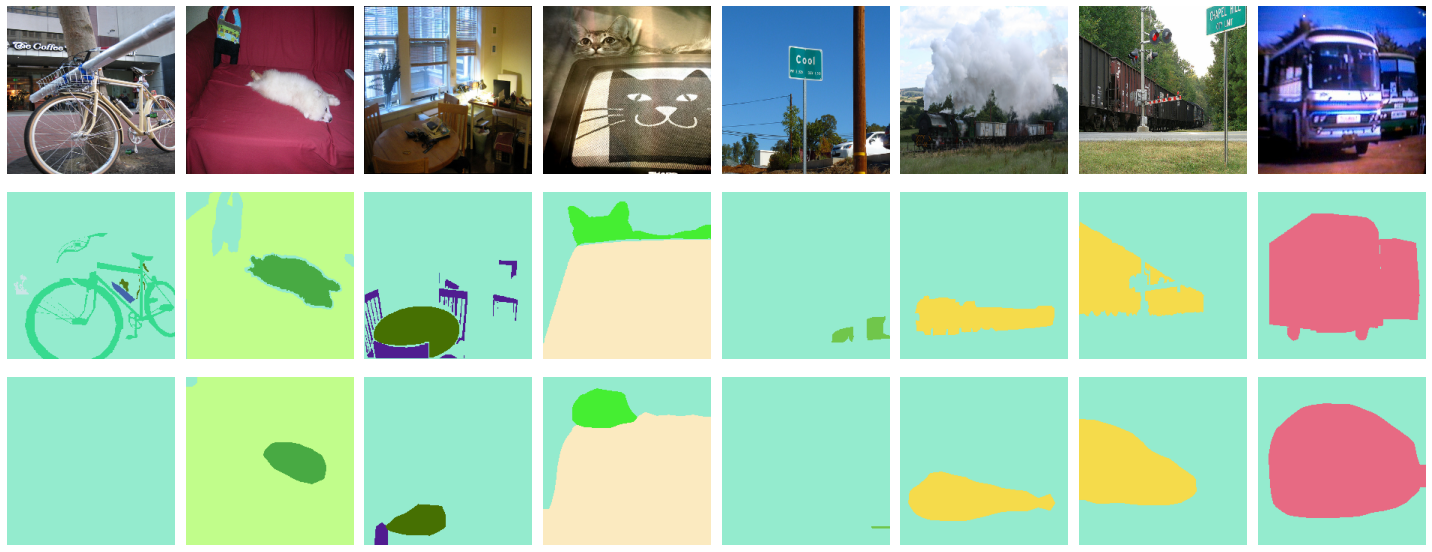

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=8, figsize=(20, 8))

for i in range(8):
    ax[0, i].imshow(tensor_to_image(images[i]))
    ax[1, i].imshow(gt_masks[i])
    ax[2, i].imshow(pr_masks[i])
    
    for j in range(3):
        ax[j, i].axis('off');

plt.tight_layout()

The model is able to capture the background  and large object, but fails to determine fine detail and small objects.